<a href="https://colab.research.google.com/github/AnikaZN/DS-Unit-2-Applied-Modeling/blob/master/module2-gradient-boosting/gradient_boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science — Applied Modeling_ 

This sprint, your project is Caterpillar Tube Pricing: Predict the prices suppliers will quote for industrial tube assemblies.

# Gradient Boosting


#### Objectives
- Do feature engineering with relational data
- Use xgboost for gradient boosting

#### Python libraries for Gradient Boosting
- [scikit-learn Gradient Tree Boosting](https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting) — slower than other libraries, but [the new version may be better](https://twitter.com/amuellerml/status/1129443826945396737)
  - Anaconda: already installed
  - Google Colab: already installed
- [xgboost](https://xgboost.readthedocs.io/en/latest/) — can accept missing values and enforce [monotonic constraints](https://xiaoxiaowang87.github.io/monotonicity_constraint/)
  - Anaconda, Mac/Linux: `conda install -c conda-forge xgboost`
  - Windows: `conda install -c anaconda py-xgboost`
  - Google Colab: already installed
- [LightGBM](https://lightgbm.readthedocs.io/en/latest/) — can accept missing values and enforce [monotonic constraints](https://blog.datadive.net/monotonicity-constraints-in-machine-learning/)
  - Anaconda: `conda install -c conda-forge lightgbm`
  - Google Colab: already installed
- [CatBoost](https://catboost.ai/) — can accept missing values and use [categorical features](https://catboost.ai/docs/concepts/algorithm-main-stages_cat-to-numberic.html) without preprocessing
  - Anaconda: `conda install -c conda-forge catboost`
  - Google Colab: `pip install catboost`

### Get data


#### Option 1. Kaggle web UI
 
Sign in to Kaggle and go to the [Caterpillar Tube Pricing](https://www.kaggle.com/c/caterpillar-tube-pricing) competition. Go to the Data page. After you have accepted the rules of the competition, use the download buttons to download the data.


#### Option 2. Kaggle API

Follow these [instructions](https://github.com/Kaggle/kaggle-api).

#### Option 3. GitHub Repo — LOCAL

If you are working locally:

1. Clone the [GitHub repo](https://github.com/LambdaSchool/DS-Unit-2-Applied-Modeling/tree/master/data/caterpillar) locally. The data is in the repo, so you don't need to download it separately.

2. Unzip the file `caterpillar-tube-pricing.zip` which is in the data folder of your local repo.

3. Unzip the file `data.zip`. 

4. Run the cell below to assign a constant named `SOURCE`, a string that points to the location of the data on your local machine. The rest of the code in the notebook will use this constant.

In [0]:
SOURCE = '../data/caterpillar/caterpillar-tube-pricing/competition_data/'

#### Option 4. GitHub Repo — COLAB

If you are working on Google Colab, uncomment and run these cells, to download the data, unzip it, and assign a constant that points to the location of the data.

In [2]:
!wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/caterpillar/caterpillar-tube-pricing.zip

--2019-08-10 01:20:54--  https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/caterpillar/caterpillar-tube-pricing.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 823789 (804K) [application/zip]
Saving to: ‘caterpillar-tube-pricing.zip.1’

caterpillar-tube-pr 100%[===================>] 804.48K  --.-KB/s    in 0.1s    

2019-08-10 01:20:54 (5.56 MB/s) - ‘caterpillar-tube-pricing.zip.1’ saved [823789/823789]



In [3]:
!unzip caterpillar-tube-pricing.zip

Archive:  caterpillar-tube-pricing.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: sample_submission.csv   
  inflating: data.zip                


In [4]:
!unzip data.zip

Archive:  data.zip
replace competition_data/bill_of_materials.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: competition_data/bill_of_materials.csv  
  inflating: competition_data/comp_adaptor.csv  
  inflating: competition_data/comp_boss.csv  
  inflating: competition_data/comp_elbow.csv  
  inflating: competition_data/comp_float.csv  
  inflating: competition_data/comp_hfl.csv  
  inflating: competition_data/comp_nut.csv  
  inflating: competition_data/comp_other.csv  
  inflating: competition_data/comp_sleeve.csv  
  inflating: competition_data/comp_straight.csv  
  inflating: competition_data/comp_tee.csv  
  inflating: competition_data/comp_threaded.csv  
  inflating: competition_data/components.csv  
  inflating: competition_data/specs.csv  
  inflating: competition_data/test_set.csv  
  inflating: competition_data/train_set.csv  
  inflating: competition_data/tube.csv  
  inflating: competition_data/tube_end_form.csv  
  inflating: competition_data/type_component.csv 

In [0]:
SOURCE = 'competition_data/'

## Do feature engineering with relational data

Here are some questions — not answers!

### `bill_of_materials`

is formatted like this:

In [6]:
import pandas as pd
materials = pd.read_csv(SOURCE + 'bill_of_materials.csv')
materials.head()

,tube_assembly_id,component_id_1,quantity_1,component_id_2,quantity_2,component_id_3,quantity_3,component_id_4,quantity_4,component_id_5,quantity_5,component_id_6,quantity_6,component_id_7,quantity_7,component_id_8,quantity_8
0,TA-00001,C-1622,2.0,C-1629,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TA-00002,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TA-00003,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TA-00004,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TA-00005,C-1624,1.0,C-1631,1.0,C-1641,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
materials.describe(exclude='number')

,tube_assembly_id,component_id_1,component_id_2,component_id_3,component_id_4,component_id_5,component_id_6,component_id_7,component_id_8
count,21198,19149,14786,4791,607,92,26,7,1
unique,21198,1079,834,509,204,62,19,4,1
top,TA-03536,C-1621,C-1628,C-1641,C-1660,C-0872,C-0378,C-1019,C-1981
freq,1,2043,1959,421,62,10,3,3,1


In [8]:
materials.isnull().sum()/len(materials)

tube_assembly_id    0.000000
component_id_1      0.096660
quantity_1          0.096660
component_id_2      0.302481
quantity_2          0.302481
component_id_3      0.773988
quantity_3          0.773658
component_id_4      0.971365
quantity_4          0.971318
component_id_5      0.995660
quantity_5          0.995660
component_id_6      0.998773
quantity_6          0.998773
component_id_7      0.999670
quantity_7          0.999670
component_id_8      0.999953
quantity_8          0.999953
dtype: float64

#### Would this be a better representation?

Could pandas melt, crosstab, and other functions help reshape the data like this?

| Crosstab | C-1622 | C-1629 | C-1312 | C-1624 | C-1631 | C-1641 | Distinct | Total |
|:--------:|:------:|--------|--------|--------|--------|--------|----------|-------|
| TA-00001 | 2      | 2      | 0      | 0      | 0      | 0      | 2        | 4     |
| TA-00002 | 0      | 0      | 2      | 0      | 0      | 0      | 1        | 2     |
| TA-00003 | 0      | 0      | 2      | 0      | 0      | 0      | 1        | 2     |
| TA-00004 | 0      | 0      | 2      | 0      | 0      | 0      | 1        | 2     |
| TA-00005 | 0      | 0      | 0      | 1      | 1      | 1      | 3        | 3     |

### `components`

Contains three representations of each component, in order of decreasing cardinality / granularity:

- `component_id`
- `name`
- `component_type_id`

What are the pros & cons of these different representations?

In [9]:
components = pd.read_csv(SOURCE + 'components.csv')
components.describe()

,component_id,name,component_type_id
count,2048,2047,2048
unique,2048,297,29
top,C-0926,FLANGE,OTHER
freq,1,350,1006


In [10]:
components.head()

,component_id,name,component_type_id
0,9999,OTHER,OTHER
1,C-0001,SLEEVE,CP-024
2,C-0002,SLEEVE,CP-024
3,C-0003,SLEEVE-FLARED,CP-024
4,C-0004,NUT,CP-026


In [11]:
components['name'].nunique()

297

### Tip/trick: Want to read all the files at once?

In [0]:
from glob import glob

#use a dictionary to store all dataframes
#see below for breakout of lines
data = {}
for path in glob(SOURCE + '*.csv'):
    df = pd.read_csv(path)
    filename = path.split('/')[-1]
    name = filename.split('.')[0]
    data[name] = df

In [13]:
glob(SOURCE + '*.csv')

['competition_data/comp_boss.csv',
 'competition_data/bill_of_materials.csv',
 'competition_data/comp_tee.csv',
 'competition_data/comp_nut.csv',
 'competition_data/tube.csv',
 'competition_data/comp_adaptor.csv',
 'competition_data/comp_sleeve.csv',
 'competition_data/comp_straight.csv',
 'competition_data/specs.csv',
 'competition_data/components.csv',
 'competition_data/comp_hfl.csv',
 'competition_data/comp_float.csv',
 'competition_data/tube_end_form.csv',
 'competition_data/comp_threaded.csv',
 'competition_data/comp_other.csv',
 'competition_data/train_set.csv',
 'competition_data/type_end_form.csv',
 'competition_data/type_component.csv',
 'competition_data/type_connection.csv',
 'competition_data/comp_elbow.csv',
 'competition_data/test_set.csv']

In [14]:
'competition_data/comp_adaptor.csv'.split('/')[-1].split('.')[0]

'comp_adaptor'

In [15]:
data['comp_adaptor']

,component_id,component_type_id,adaptor_angle,overall_length,end_form_id_1,connection_type_id_1,length_1,thread_size_1,thread_pitch_1,nominal_size_1,end_form_id_2,connection_type_id_2,length_2,thread_size_2,thread_pitch_2,nominal_size_2,hex_size,unique_feature,orientation,weight
0,C-0005,CP-028,NaN,58.40,A-001,B-001,NaN,1.312,12.0,NaN,A-001,B-004,NaN,1.000,11.5,NaN,34.93,No,No,0.206
1,C-0006,CP-028,NaN,34.80,A-001,B-001,NaN,0.437,20.0,NaN,A-001,B-005,NaN,0.750,16.0,NaN,22.20,No,No,0.083
2,C-1435,CP-028,NaN,20.30,A-007,B-004,NaN,NaN,NaN,15.88,A-001,B-007,NaN,0.875,18.0,NaN,22.22,No,No,0.023
3,C-1546,CP-028,NaN,26.40,A-007,B-004,NaN,0.125,27.0,NaN,A-001,B-004,NaN,0.125,27.0,NaN,15.88,No,No,0.026
4,C-1583,CP-028,NaN,44.50,A-001,B-005,NaN,1.312,12.0,NaN,A-007,B-005,NaN,1.062,12.0,NaN,38.10,No,No,0.256
5,C-1634,CP-028,NaN,34.50,A-001,B-005,NaN,0.750,16.0,NaN,A-001,B-002,NaN,0.687,16.0,NaN,22.23,No,No,0.060
6,C-1975,CP-028,NaN,13.20,A-007,B-007,NaN,NaN,NaN,3.18,A-001,B-007,NaN,0.312,28.0,NaN,NaN,No,No,0.005
7,C-0428,CP-028,NaN,26.99,A-001,B-004,NaN,0.250,18.0,NaN,A-007,NaN,NaN,NaN,NaN,9.52,17.46,No,No,0.032
8,C-0443,CP-028,NaN,22.35,A-007,B-007,NaN,NaN,NaN,19.05,9999,9999,NaN,1.062,16.0,NaN,26.97,No,No,NaN
9,C-0823,CP-028,NaN,16.80,A-007,B-007,NaN,NaN,NaN,9.52,A-001,9999,NaN,0.625,18.0,9.52,15.75,No,No,0.014


In [16]:
data['comp_sleeve'].head()

,component_id,component_type_id,connection_type_id,length,intended_nut_thread,intended_nut_pitch,unique_feature,plating,orientation,weight
0,C-0001,CP-024,B-001,17.3,1.062,12,No,No,No,0.013
1,C-0002,CP-024,B-001,11.2,0.500,20,No,No,No,0.005
2,C-0003,CP-024,B-001,19.3,1.187,12,No,No,No,0.014
3,C-0048,CP-024,B-002,9.5,0.562,18,No,No,No,0.006
4,C-0049,CP-024,B-002,9.5,0.812,16,No,No,No,0.012


## Example solution for last assignment 🚜

In [17]:
!pip install category_encoders

In [0]:
import category_encoders as ce
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

def wrangle(X):
    X = X.copy()
    
    # Engineer date features
    X['quote_date'] = pd.to_datetime(X['quote_date'], infer_datetime_format=True)
    X['quote_date_year'] = X['quote_date'].dt.year
    X['quote_date_month'] = X['quote_date'].dt.month
    X = X.drop(columns='quote_date')
    
    # Merge tube data
    tube = pd.read_csv(SOURCE + 'tube.csv')
    X = X.merge(tube, how='left')
    
    # Engineer features from bill_of_materials
    materials = pd.read_csv(SOURCE + 'bill_of_materials.csv')
    
    materials['components_total'] = (materials['quantity_1'].fillna(0) + 
                                     materials['quantity_2'].fillna(0) + 
                                     materials['quantity_3'].fillna(0) + 
                                     materials['quantity_4'].fillna(0) + 
                                     materials['quantity_5'].fillna(0) + 
                                     materials['quantity_6'].fillna(0) + 
                                     materials['quantity_7'].fillna(0) + 
                                     materials['quantity_8'].fillna(0))

    materials['components_distinct'] = (materials['component_id_1'].notnull().astype(int) + 
                                        materials['component_id_2'].notnull().astype(int) + 
                                        materials['component_id_3'].notnull().astype(int) + 
                                        materials['component_id_4'].notnull().astype(int) + 
                                        materials['component_id_5'].notnull().astype(int) + 
                                        materials['component_id_6'].notnull().astype(int) + 
                                        materials['component_id_7'].notnull().astype(int) + 
                                        materials['component_id_8'].notnull().astype(int))
    
    # Merge selected features from bill_of_materials
    # Just use the first component_id, ignore the others for now!
    features = ['tube_assembly_id', 'component_id_1', 'components_total', 'components_distinct']
    X = X.merge(materials[features], how='left')
    
    # Get component_type_id (has lower cardinality than component_id)
    components = pd.read_csv(SOURCE + 'components.csv')
    components = components.rename(columns={'component_id': 'component_id_1'})
    features = ['component_id_1', 'component_type_id']
    X = X.merge(components[features], how='left')
    
    # Count the number of specs for the tube assembly
    specs = pd.read_csv(SOURCE + 'specs.csv')
    specs['specs_total'] = specs.drop(columns=['tube_assembly_id']).count(axis=1)
    features = ['tube_assembly_id', 'specs_total', 'spec1']
    X = X.merge(specs[features], how='left')
    
    # Drop tube_assembly_id because our goal is to predict unknown assemblies
    X = X.drop(columns='tube_assembly_id')
    
    return X


# Read data
trainval = pd.read_csv(SOURCE + 'train_set.csv')
test = pd.read_csv(SOURCE + 'test_set.csv')

# Split into train & validation sets
# All rows for a given tube_assembly_id should go in either train or validation
trainval_tube_assemblies = trainval['tube_assembly_id'].unique()
train_tube_assemblies, val_tube_assemblies = train_test_split(
    trainval_tube_assemblies, random_state=42)
train = trainval[trainval.tube_assembly_id.isin(train_tube_assemblies)]
val = trainval[trainval.tube_assembly_id.isin(val_tube_assemblies)]

# Wrangle train, validation, and test sets
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

#create a new feature called surface area
train['surface_area'] = (train['diameter'] * .5 * 3.14159 * 2 * train['length']) + (train['diameter'] * 2 * 3.14159 *.5 *2)
val['surface_area'] = (val['diameter'] * .5 * 3.14159 * 2 * val['length']) + (val['diameter'] * 2 * 3.14159 *.5 *2)
test['surface_area'] = (test['diameter'] * .5 * 3.14159 * 2 * test['length']) + (test['diameter'] * 2 * 3.14159 *.5 *2)

#create a feature called overall usage
train['overall_usage'] = train['quantity'] * train['annual_usage']
val['overall_usage'] = val['quantity'] * val['annual_usage']
test['overall_usage'] = test['quantity'] * test['annual_usage']

# Arrange X matrix and y vector (log-transformed)
target = 'cost'
X_train = train.drop(columns=target)
X_val = val.drop(columns=target)
X_test = test.drop(columns='id')
y_train = train[target]
y_val = val[target]
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

In [0]:
# #create a new feature called surface area

# train['surface_area'] = (train['diameter'] * .5 * 3.14159 * 2 * train['length']) + (train['diameter'] * 2 * 3.14159 *.5 *2)
# val['surface_area'] = (val['diameter'] * .5 * 3.14159 * 2 * val['length']) + (val['diameter'] * 2 * 3.14159 *.5 *2)
# test['surface_area'] = (test['diameter'] * .5 * 3.14159 * 2 * test['length']) + (test['diameter'] * 2 * 3.14159 *.5 *2)

In [79]:
%%time

# Make pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit
pipeline.fit(X_train, y_train_log)

# Validate
y_pred_log = pipeline.predict(X_val)
print('Validation Error', rmse(y_val_log, y_pred_log))

# Predict
def generate_submission(estimator, X_test, filename):
    y_pred_log = estimator.predict(X_test)
    y_pred = np.expm1(y_pred_log)  # Convert from log-dollars to dollars
    submission = pd.read_csv(SOURCE + '../sample_submission.csv')
    submission['cost'] = y_pred
    submission.to_csv(filename, index=False)
    
generate_submission(pipeline, X_test, 'submission-02.csv')

Validation Error 0.3021066979481973
CPU times: user 24.8 s, sys: 110 ms, total: 24.9 s
Wall time: 13.1 s


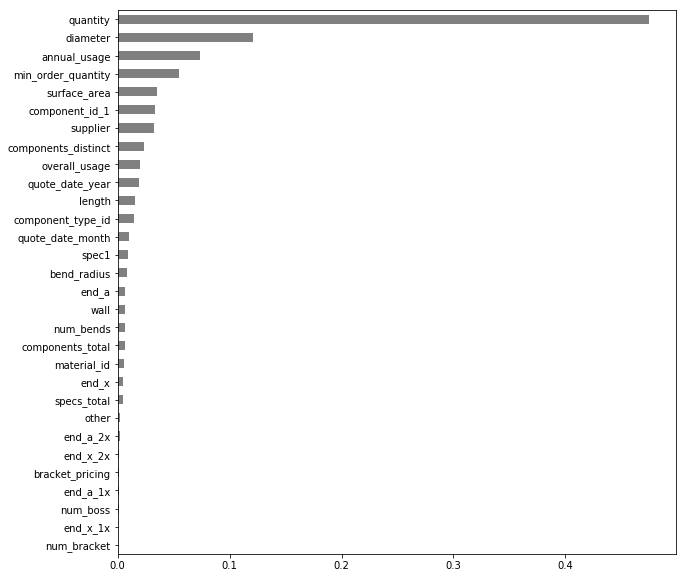

In [80]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
rf = pipeline.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_, X_train.columns)
importances.sort_values().plot.barh(color='grey');

## Use xgboost for gradient boosting

#### [XGBoost Python API Reference: Scikit-Learn API](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)

In [0]:
#boosting algorithms for dummies:

#not all datapoints are equally valuable/informative
#focus on observations that initially did poorly
#identify potential new data points

In [82]:
from xgboost import XGBRegressor as xgbr

# Make pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    xgbr(n_estimators=1000, n_job=-1)
)

# Fit
pipeline.fit(X_train, y_train_log)

# Validate
y_pred_log = pipeline.predict(X_val)
print('Validation Error', rmse(y_val_log, y_pred_log))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:26:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation Error 0.27173294305616796


In [0]:
generate_submission(pipeline, X_test, 'submission_xgb_1000.csv')

#### Jason Brownlee, [Avoid Overfitting By Early Stopping With XGBoost In Python](https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/)

In [0]:
import category_encoders as ce

encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

In [0]:
eval_set = [(X_train_encoded, y_train_log),
           (X_val_encoded, y_val_log)]

In [86]:
model = xgbr(n_estimators=1000, n_job=-1)

model.fit(X_train_encoded, y_train_log, eval_set=eval_set,
         eval_metric = 'rmse', early_stopping_rounds = 10)

[02:27:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.71924	validation_1-rmse:1.70846
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.56505	validation_1-rmse:1.55452
[2]	validation_0-rmse:1.42805	validation_1-rmse:1.41988


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[3]	validation_0-rmse:1.30357	validation_1-rmse:1.29598
[4]	validation_0-rmse:1.19163	validation_1-rmse:1.1844
[5]	validation_0-rmse:1.09303	validation_1-rmse:1.08759
[6]	validation_0-rmse:1.00438	validation_1-rmse:0.999653
[7]	validation_0-rmse:0.927417	validation_1-rmse:0.92412
[8]	validation_0-rmse:0.858431	validation_1-rmse:0.85634
[9]	validation_0-rmse:0.798847	validation_1-rmse:0.798451
[10]	validation_0-rmse:0.745458	validation_1-rmse:0.747163
[11]	validation_0-rmse:0.696891	validation_1-rmse:0.699686
[12]	validation_0-rmse:0.656341	validation_1-rmse:0.661168
[13]	validation_0-rmse:0.620057	validation_1-rmse:0.625259
[14]	validation_0-rmse:0.589003	validation_1-rmse:0.596
[15]	validation_0-rmse:0.561222	validation_1-rmse:0.568475
[16]	validation_0-rmse:0.538225	validation_1-rmse:0.547088
[17]	validation_0-rmse:0.515783	validation_1-rmse:0.52494
[18]	validation_0-rmse:0.498607	validation_1-rmse:0.508155
[19]	validation_0-rmse:0.480514	validation_1-rmse:0.491378
[20]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_job=-1, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

#### Kaggle RMSLE: 0.29454

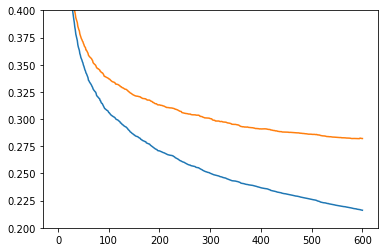

In [87]:
results = model.evals_result()

train_rmse = results['validation_0']['rmse']
val_rmse = results['validation_1']['rmse']

epochs = range(0, len(train_rmse))

plt.plot(epochs, train_rmse, label='train')
plt.plot(epochs, val_rmse, label='val')
plt.ylim(0.2, 0.4);

In [88]:
pip install catboost

In [89]:
from catboost import CatBoostRegressor as cbr

# Make pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    cbr(learning_rate = 0.3))

# Fit
pipeline.fit(X_train, y_train_log)

# Validate
y_pred_log = pipeline.predict(X_val)
print('Validation Error', rmse(y_val_log, y_pred_log))

0:	learn: 1.7135109	total: 32.9ms	remaining: 32.9s
1:	learn: 1.2745217	total: 69.8ms	remaining: 34.8s
2:	learn: 0.9632865	total: 98.1ms	remaining: 32.6s
3:	learn: 0.7612636	total: 128ms	remaining: 31.9s
4:	learn: 0.6233118	total: 158ms	remaining: 31.3s
5:	learn: 0.5364693	total: 186ms	remaining: 30.9s
6:	learn: 0.4750213	total: 216ms	remaining: 30.6s
7:	learn: 0.4355777	total: 257ms	remaining: 31.9s
8:	learn: 0.4127685	total: 285ms	remaining: 31.4s
9:	learn: 0.3987296	total: 313ms	remaining: 31s
10:	learn: 0.3887591	total: 341ms	remaining: 30.6s
11:	learn: 0.3748359	total: 372ms	remaining: 30.6s
12:	learn: 0.3699370	total: 401ms	remaining: 30.4s
13:	learn: 0.3628013	total: 429ms	remaining: 30.2s
14:	learn: 0.3587443	total: 463ms	remaining: 30.4s
15:	learn: 0.3512556	total: 495ms	remaining: 30.5s
16:	learn: 0.3460214	total: 522ms	remaining: 30.2s
17:	learn: 0.3434816	total: 547ms	remaining: 29.8s
18:	learn: 0.3412080	total: 573ms	remaining: 29.6s
19:	learn: 0.3355483	total: 604ms	remain

In [90]:
import lightgbm as lgbm

# Make pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    lgbm.sklearn.LGBMRegressor(learning_rate = 0.2))

# Fit
pipeline.fit(X_train, y_train_log)

# Validate
y_pred_log = pipeline.predict(X_val)
print('Validation Error', rmse(y_val_log, y_pred_log))

Validation Error 0.2653149378727434


In [0]:
#csv
generate_submission(pipeline, X_test, 'submission_xgb_1000.csv')

from google.colab import files
files.download('submission_xgb_1000.csv')

### Understand the difference between boosting & bagging

Boosting (used by Gradient Boosting) is different than Bagging (used by Random Forests). 

[_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8.2.3, Boosting:

>Recall that bagging involves creating multiple copies of the original training data set using the bootstrap, fitting a separate decision tree to each copy, and then combining all of the trees in order to create a single predictive model.

>**Boosting works in a similar way, except that the trees are grown _sequentially_: each tree is grown using information from previously grown trees.**

>Unlike fitting a single large decision tree to the data, which amounts to _fitting the data hard_ and potentially overfitting, the boosting approach instead _learns slowly._ Given the current model, we fit a decision tree to the residuals from the model.

>We then add this new decision tree into the fitted function in order to update the residuals. Each of these trees can be rather small, with just a few terminal nodes. **By fitting small trees to the residuals, we slowly improve fˆ in areas where it does not perform well.**

>Note that in boosting, unlike in bagging, the construction of each tree depends strongly on the trees that have already been grown.

# Assignment
- Continue to participate in the [Kaggle Caterpillar competition](https://www.kaggle.com/c/caterpillar-tube-pricing).
- Do more feature engineering. - Below .26727
- Use xgboost for gradient boosting.
- Submit new predictions.
- Commit your notebook to your fork of the GitHub repo.

## Stretch Goals
- Improve your scores on Kaggle.
- Make visualizations and share on Slack.
- Look at [Kaggle Kernels](https://www.kaggle.com/c/caterpillar-tube-pricing/kernels) for ideas about feature engineerng and visualization.
- Look at the bonus notebook in the repo, about Monotonic Constraints with Gradient Boosting.
- Read more about gradient boosting:
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [A Kaggle Master Explains Gradient Boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)
  - [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
  - [Boosting](https://www.youtube.com/watch?v=GM3CDQfQ4sw) (3 minute video)